# Fantasy Premier League Football Team Selector
The aim of this notebook is to use machine learning to help select a team that could achieve a strong score in Fantasy Premier League.

Using historical full season statistics, I aim to create a machine learning model that uses a players stats in the previous year to predict their points performance in the following season.

With these predictions - supplemented with some human adjustments do to transfer rumours and factors difficult for the machine to assess! - we then use brute force to select team combinations.

Finally we choose the team combination that offers the maximum predicted points - subject to the constraints of the FPL rules.

### Note
This notebook assumes the reader has at least some familiarity with Python, machine learning, football and the Fantasy Premier League statistics (though rules and constraints are explained).

## Strategy - find players with highest (consistent) points per game
For the players in the upcoming season where there is sufficient data from the previous season - we aim to use machine learning to build a model to predict points per game (based on their performance in the previous season).

We will use only players that play a sigificant amount - so we avoid inconsistent performers.

But this means there is a big drawback - we exclude players that didn't play in the Premier League in the previous season. Newly promoted teams are excluded and new transfers from other leagues are excluded.

Also, we're playing a long-term strategy - rather than looking at week-by-week data. So the aim will be to pick a team that never needs to change as it should perform well over the season as a whole - unless there are injuries/transfers in which case an update will be needed of course!

### Human input required!
This model can identify players that should achieve high points per game - but human factors will give better intuition on the likelihood that a player plays a lot in this season - I chose this approach rather than assuming playing time would be the same/similar to the previous season.

## Import modules

In [56]:
import requests
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor

from itertools import combinations
import time

pd.options.display.max_columns = 50 # allow for easier reading of finalised dataframes

# below code used to originally download latest pre-season data (on 12th Sept 2020)
#- but subsequently I saved it (so it doesn't update after season has begun)
    # url = "https://fantasy.premierleague.com/api/bootstrap-static/"
    # response = requests.get(url)
    # response.raise_for_status() # checks site loads and raises exception, if not
    # json = response.json()
    # teams_df = pd.DataFrame(json["teams"])
    # teams_df.rename(columns = {'code': 'team_code', 'name': 'team_name'}, inplace = True)
    # elements_df = pd.DataFrame(json["elements"])

## Download latest season data
Below we download the latest available data for the 2020-21 pre-season.

The statistics are a mixture of old and new statistics - to be updated as the season progresses.

The only data we will use from this dataset for machine learning are:
   * from `team_df` - "team_name" and "strength_" statistics - we will map the team names and attack/defence stats into the historical data (as it wasn't easily available so we will have to estimate that team strength is largely unchanged in the past few years)
   * from `elements_df` - "now_cost" is the latest accurate cost which we'll use to select the teams at the end

In [57]:
teams_df = pd.read_csv(r"C:\Users\Dexx6\Documents\MyProjects\Jupyter Notebooks\FPL_data\data\2020-21\pre-season_teams.csv")
elements_df = pd.read_csv(r"C:\Users\Dexx6\Documents\MyProjects\Jupyter Notebooks\FPL_data\data\2020-21\pre-season_elements.csv")

In [58]:
teams_df # the only useful columns in this dataframe are "team_name" and team "strength_" columns

,Unnamed: 0,team_code,draw,form,id,loss,team_name,played,points,position,short_name,strength,team_division,unavailable,win,strength_overall_home,strength_overall_away,strength_attack_home,strength_attack_away,strength_defence_home,strength_defence_away,pulse_id
0,0,3,0,NaN,1,0,Arsenal,0,0,0,ARS,4,NaN,False,0,1190,1270,1190,1200,1160,1270,1
1,1,7,0,NaN,2,0,Aston Villa,0,0,0,AVL,2,NaN,False,0,1050,1080,1010,1080,1000,1110,2
2,2,36,0,NaN,3,0,Brighton,0,0,0,BHA,2,NaN,False,0,1070,1070,1100,1130,1060,1060,131
3,3,90,0,NaN,4,0,Burnley,0,0,0,BUR,3,NaN,False,0,1140,1150,1130,1240,1050,1170,43
4,4,8,0,NaN,5,0,Chelsea,0,0,0,CHE,4,NaN,False,0,1200,1260,1140,1270,1240,1250,4
5,5,31,0,NaN,6,0,Crystal Palace,0,0,0,CRY,3,NaN,False,0,1080,1070,1080,1190,1010,1040,6
6,6,11,0,NaN,7,0,Everton,0,0,0,EVE,3,NaN,False,0,1100,1180,1090,1190,1150,1180,7
7,7,54,0,NaN,8,0,Fulham,0,0,0,FUL,2,NaN,False,0,1000,1030,1010,1030,1000,1050,34
8,8,13,0,NaN,9,0,Leicester,0,0,0,LEI,4,NaN,False,0,1180,1230,1180,1260,1220,1250,26
9,9,2,0,NaN,10,0,Leeds,0,0,0,LEE,2,NaN,False,0,1030,1040,1040,1070,990,990,9


In [59]:
elements_df # there are far too many columns here - we pick out key features more clearly later

,Unnamed: 0,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,dreamteam_count,element_type,ep_next,ep_this,event_points,first_name,form,id,in_dreamteam,news,news_added,now_cost,photo,points_per_game,second_name,selected_by_percent,special,...,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,influence_rank,influence_rank_type,creativity_rank,creativity_rank_type,threat_rank,threat_rank_type,ict_index_rank,ict_index_rank_type,corners_and_indirect_freekicks_order,corners_and_indirect_freekicks_text,direct_freekicks_order,direct_freekicks_text,penalties_order,penalties_text
0,0,NaN,NaN,37605,0,0,0,0,0,3,3.4,NaN,0,Mesut,0.0,1,False,NaN,NaN,70,37605.jpg,2.9,Özil,1.4,False,...,0,0,1,0,0,1,256,223.6,582.9,190.0,99.8,260,113,36,30,178,98,138,74,3.0,NaN,NaN,NaN,NaN,NaN
1,1,0.0,NaN,39476,0,0,0,0,0,2,0.0,NaN,0,Sokratis,0.0,2,False,Calf injury - Expected back 19 Sep,2020-09-11T11:00:08.600094Z,50,39476.jpg,3.0,Papastathopoulos,0.3,False,...,0,0,6,0,0,5,305,436.2,36.8,110.0,58.5,146,54,302,107,229,66,239,75,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.0,NaN,41270,0,0,0,0,0,2,0.0,NaN,0,David,0.0,3,False,Neck - Unknown return date,2020-09-10T14:30:11.632386Z,55,41270.jpg,2.8,Luiz Moreira Marinho,1.4,False,...,0,0,5,2,0,10,494,701.6,106.7,211.0,102.1,50,18,227,62,164,32,133,35,NaN,NaN,2.0,NaN,NaN,NaN
3,3,NaN,NaN,54694,0,0,0,0,0,3,5.0,NaN,0,Pierre-Emerick,0.0,4,False,NaN,NaN,120,54694.jpg,5.7,Aubameyang,48.4,False,...,0,0,3,1,0,37,807,1006.0,479.6,1369.0,285.2,8,4,56,44,9,3,11,7,NaN,NaN,4.0,NaN,1.0,NaN
4,4,NaN,NaN,58822,0,0,0,0,0,2,3.1,NaN,0,Cédric,0.0,5,False,NaN,NaN,50,58822.jpg,2.9,Soares,0.6,False,...,0,0,1,0,0,3,286,349.0,218.9,118.0,68.7,186,69,163,35,228,65,207,60,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516,516,NaN,NaN,428610,0,0,0,0,0,3,1.0,NaN,0,Bruno André,0.0,475,False,NaN,NaN,45,428610.jpg,1.0,Cavaco Jordao,0.6,False,...,0,0,0,0,0,0,4,2.6,10.4,0.0,1.3,380,163,339,158,439,174,380,163,NaN,NaN,NaN,NaN,NaN,NaN
517,517,NaN,NaN,474003,0,0,0,0,0,4,1.3,NaN,0,Leonardo,0.0,476,False,NaN,NaN,50,474003.jpg,0.0,Campana,0.3,False,...,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,490,55,487,55,485,55,490,55,NaN,NaN,NaN,NaN,NaN,NaN
518,518,NaN,NaN,449988,0,0,0,0,0,4,1.5,NaN,0,Fabio,0.0,504,False,NaN,NaN,55,449988.jpg,0.0,Silva,1.3,False,...,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,509,61,509,61,507,61,509,61,NaN,NaN,NaN,NaN,NaN,NaN
519,519,NaN,NaN,111291,0,0,0,0,0,2,2.1,NaN,0,Fernando,0.0,505,False,NaN,NaN,50,111291.jpg,0.0,Marçal,0.3,False,...,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,472,184,469,184,464,183,472,184,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
# we add the player's team "strength_attack_", "strength_defence_" and "team_name" columns
# and we set the index to be the unique player "code"

elements_df = elements_df.merge(
                teams_df[["team_code", "strength_attack_home", "strength_attack_away",
                           "strength_defence_home", "strength_defence_away",
                           "team_name"]],
                on = 'team_code', how = 'left').set_index("code")

In [61]:
elements_df.columns # there are many columns, we'll trim it significantly

Index(['Unnamed: 0', 'chance_of_playing_next_round',
       'chance_of_playing_this_round', 'cost_change_event',
       'cost_change_event_fall', 'cost_change_start', 'cost_change_start_fall',
       'dreamteam_count', 'element_type', 'ep_next', 'ep_this', 'event_points',
       'first_name', 'form', 'id', 'in_dreamteam', 'news', 'news_added',
       'now_cost', 'photo', 'points_per_game', 'second_name',
       'selected_by_percent', 'special', 'squad_number', 'status', 'team',
       'team_code', 'total_points', 'transfers_in', 'transfers_in_event',
       'transfers_out', 'transfers_out_event', 'value_form', 'value_season',
       'web_name', 'minutes', 'goals_scored', 'assists', 'clean_sheets',
       'goals_conceded', 'own_goals', 'penalties_saved', 'penalties_missed',
       'yellow_cards', 'red_cards', 'saves', 'bonus', 'bps', 'influence',
       'creativity', 'threat', 'ict_index', 'influence_rank',
       'influence_rank_type', 'creativity_rank', 'creativity_rank_type',
       

## Historical data for model training
Below we download the player data (equivalent to `elements_df` above) from the four previous seasons that are available.

In [62]:
# data source: https://github.com/vaastav/Fantasy-Premier-League

data_2016_17 = pd.read_csv(r"C:\Users\Dexx6\Documents\MyProjects\Jupyter Notebooks\FPL_data\data\2016-17\players_raw.csv")
data_2017_18 = pd.read_csv(r"C:\Users\Dexx6\Documents\MyProjects\Jupyter Notebooks\FPL_data\data\2017-18\players_raw.csv")
data_2018_19 = pd.read_csv(r"C:\Users\Dexx6\Documents\MyProjects\Jupyter Notebooks\FPL_data\data\2018-19\players_raw.csv")
data_2019_20 = pd.read_csv(r"C:\Users\Dexx6\Documents\MyProjects\Jupyter Notebooks\FPL_data\data\2019-20\players_raw.csv")

In [63]:
# we merge in the same way as with the latest data
# adding team strength and team name stats and indexing by unique player code

data_2016_17 = data_2016_17.merge(teams_df[["team_code", "team_name",
                        "strength_attack_home", "strength_attack_away",
                        "strength_defence_home", "strength_defence_away"
                        ]],
                    on = 'team_code', how = 'left').set_index("code")
data_2017_18 = data_2017_18.merge(teams_df[["team_code", "team_name",
                        "strength_attack_home", "strength_attack_away",
                        "strength_defence_home", "strength_defence_away"
                        ]],
                    on = 'team_code', how = 'left').set_index("code")
data_2018_19 = data_2018_19.merge(teams_df[["team_code", "team_name",
                        "strength_attack_home", "strength_attack_away",
                        "strength_defence_home", "strength_defence_away"
                        ]],
                    on = 'team_code', how = 'left').set_index("code")
data_2019_20 = data_2019_20.merge(teams_df[["team_code", "team_name",
                        "strength_attack_home", "strength_attack_away",
                        "strength_defence_home", "strength_defence_away"
                        ]],
                    on = 'team_code', how = 'left').set_index("code")

In [64]:
data_2019_20.sample(5)

,assists,bonus,bps,chance_of_playing_next_round,chance_of_playing_this_round,clean_sheets,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,creativity,creativity_rank,creativity_rank_type,dreamteam_count,element_type,ep_next,ep_this,event_points,first_name,form,goals_conceded,goals_scored,ict_index,ict_index_rank,ict_index_rank_type,...,saves,second_name,selected_by_percent,special,squad_number,status,team,team_code,threat,threat_rank,threat_rank_type,total_points,transfers_in,transfers_in_event,transfers_out,transfers_out_event,value_form,value_season,web_name,yellow_cards,team_name,strength_attack_home,strength_attack_away,strength_defence_home,strength_defence_away
code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
102826,2,3,378,100,100,9,0,0,-5,5,403.2,99,19,0,2,4.3,3.9,0,Benjamin,2.4,13,0,75.5,214,59,...,0,Mendy,1.6,False,None,a,11,43,106.0,271,79,74,390888,0,320067,0,0.4,13.5,Mendy,3,Man City,1250.0,1340.0,1340.0,1350.0
116216,5,9,352,100,100,4,0,0,-2,2,585.4,38,31,3,3,3.8,3.2,0,Leandro,3.7,34,5,153.2,64,36,...,0,Trossard,0.5,False,None,a,4,36,540.0,67,35,104,150143,0,165710,0,0.6,17.9,Trossard,0,Brighton,1100.0,1130.0,1060.0,1060.0
20310,0,0,74,None,None,1,0,0,-2,2,0.0,634,65,0,1,0.0,0.9,6,Willy,0.9,7,0,9.0,429,30,...,10,Caballero,0.2,False,None,a,6,8,0.0,628,62,13,12472,0,19528,0,0.2,2.7,Caballero,0,Chelsea,1140.0,1270.0,1240.0,1250.0
195851,2,6,310,100,100,3,0,0,-2,2,238.4,175,109,0,3,1.5,1.5,1,Scott,1.0,20,3,96.4,163,83,...,0,McTominay,1.0,False,None,a,12,1,310.0,131,71,74,428717,0,437366,0,0.2,15.4,McTominay,2,Man Utd,1250.0,1260.0,1200.0,1290.0
15749,0,0,0,0,0,0,0,0,-3,3,0.0,537,34,0,1,0.0,0.0,0,Joe,0.0,0,0,0.0,556,54,...,0,Hart,1.0,False,None,u,5,90,0.0,509,28,0,28406,0,105819,0,0.0,0.0,Hart,0,Burnley,1130.0,1240.0,1050.0,1170.0


### Check that columns/features match up between dataframes

We check the size of the dataframes and check for unique columns from year to year - we won't be able to use these.

In [65]:
prev_seasons = [data_2016_17, data_2017_18, data_2018_19, data_2019_20]

for df in prev_seasons:
    print("size in (row, col):", df.shape)

size in (row, col): (683, 61)
size in (row, col): (647, 62)
size in (row, col): (624, 62)
size in (row, col): (666, 65)


In [66]:
data_2016_17.columns ^ data_2019_20.columns # symmetric difference operator i.e. unique to either dataframe

Index(['creativity_rank', 'creativity_rank_type', 'ea_index', 'ict_index_rank',
       'ict_index_rank_type', 'influence_rank', 'influence_rank_type',
       'loaned_in', 'loaned_out', 'loans_in', 'loans_out', 'news_added',
       'threat_rank', 'threat_rank_type'],
      dtype='object')

We also check for which columns are unique from the latest updated data compared to the historical data.

In [67]:
data_2019_20.columns ^ elements_df.columns # symmetric difference operator i.e. unique to either dataframe

Index(['Unnamed: 0', 'corners_and_indirect_freekicks_order',
       'corners_and_indirect_freekicks_text', 'direct_freekicks_order',
       'direct_freekicks_text', 'penalties_order', 'penalties_text'],
      dtype='object')

## Feature selection
We can now choose our features, avoiding any of the columns from above which aren't consistent across all dataframes.

Based on a few iterations with this workbook, the below are the features I believe had the most potential to correlate with the following season's performance.

Though only for players that have significant (and consistent) playing time from one season to another.

In [68]:
features = ['first_name', 'second_name', 'team_name', 'element_type',  'now_cost',
            'selected_by_percent',
            'influence', 'creativity', 'threat',
            'bps', 'points_per_game', 'total_points',
            'minutes', 'goals_scored', 'assists',
            'clean_sheets', 'goals_conceded', 'own_goals',
            'penalties_saved', 'penalties_missed',
            'yellow_cards', 'red_cards', 'saves',
            "strength_attack_home", "strength_attack_away",
            "strength_defence_home", "strength_defence_away"
            ]


| Feature | Description |
| :--- | ------- |
| **element_type** | Player position (1 = goalkeeper, 2 = defender, 3 = midfielder, 4 = forward |
| **now_cost** | £ "cost" in Fantasy Premier League (squads of 15 are selected with total budget of £1000) |
| **influence** | Player impact on a match, calculated by FPL |
| **creativity** | A player's goal chance creation impact on a match, calculated by FPL |
| **threat** | A player's goal threat in a match, calculated by FPL |
| **bps** | Total bonus points in the season (top 3 players in a match score 3, 2, and 1 bonus points, respectively) |
| **points_per_game** | Average FPL points per game played |
| **total_points** | Total FPL points in the season |
| **minutes** | Minutes played in the total season |
| **goals_scored** | Goals scored by player in the total season |
| **assists** | Assists by player in the total season |
| **clean_sheets** | Team clean sheets (concede 0 goals in a match) in the total season |
| **goals_conceded** | Team goals conceded in the total season |
| **own_goals** | Own goals scored by a player in the total season |
| **penalties_saved** | Penalties saved by a player in the total season |
| **penalties_missed** | Penalties missed by a player in the total season |
| **yellow_cards** | Yellow cards received in the total season |
| **red_cards** | Red cards received in the total season |
| **saves** | Shots saved by a player in the total season |
| **strength_attack_home** | Team's attacking strength index (calculated by FPL) for home matches |
| **strength_attack_away** | Team's attacking strength index (calculated by FPL) for away matches |
| **strength_defence_home** | Team's defending strength index (calculated by FPL) for home matches |
| **strength_defence_away** | Team's defending strength index (calculated by FPL) for away matches |

In [69]:
this_season = elements_df[features]
this_season.sample(5)

,first_name,second_name,team_name,element_type,now_cost,selected_by_percent,influence,creativity,threat,bps,points_per_game,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,strength_attack_home,strength_attack_away,strength_defence_home,strength_defence_away
code,,,,,,,,,,,,,,,,,,,,,,,,,,,
219924,Issa,Diop,West Ham,2,45,1.8,610.0,64.3,210.0,424,2.4,76,2765,3,1,4,54,0,0,0,8,0,0,1090,1090,1040,1210
214048,Max,Kilman,Wolves,2,40,1.9,35.2,1.2,0.0,24,1.7,5,184,0,0,0,2,0,0,0,0,0,0,1230,1250,1170,1200
47390,Neil,Taylor,Aston Villa,2,45,0.4,157.6,79.7,29.0,163,1.6,22,1088,0,0,2,25,0,0,0,2,0,0,1010,1080,1000,1110
40145,Jack,Cork,Burnley,3,50,0.0,313.2,198.2,311.0,301,2.3,70,2614,0,0,12,41,0,0,0,1,0,0,1130,1240,1050,1170
169359,Matt,Targett,Aston Villa,2,45,1.1,503.8,432.9,130.0,433,2.9,80,2291,1,3,5,40,0,0,0,4,0,0,1010,1080,1000,1110


In [70]:
this_season.isna().any().any() # check for any null values for any rows/columns

False

In [71]:
df_16_17 = data_2016_17[features]
df_17_18 = data_2017_18[features]
df_18_19 = data_2018_19[features]
df_19_20 = data_2019_20[features]

In [72]:
print(df_16_17.isna().sum())  # check for any null values and identify the columns (same columns have nulls in other dfs)

first_name                 0
second_name                0
team_name                249
element_type               0
now_cost                   0
selected_by_percent        0
influence                  0
creativity                 0
threat                     0
bps                        0
points_per_game            0
total_points               0
minutes                    0
goals_scored               0
assists                    0
clean_sheets               0
goals_conceded             0
own_goals                  0
penalties_saved            0
penalties_missed           0
yellow_cards               0
red_cards                  0
saves                      0
strength_attack_home     249
strength_attack_away     249
strength_defence_home    249
strength_defence_away    249
dtype: int64


### Imputing data to null values
The missing data in this case is because of players that (in that season) played for teams that are not in the latest season of the Premier League.

This means the team was relegated subsequently. We will therefore set the team_name to "Other" and give the "strength_" scores a suitable value that is below that of the current teams (as the team ended up being relegated).

I note that of course team "strength" likely fluctuated season by season - but with a lack of better data an assumption of a fixed score across all seaons (as we've applied with the other teams) seems fair.

Also as over the past few years the 'best/worst' teams hasn't changed hugely for most teams (with a few exceptions), this shouldn't skew our results too much - hopefully!

In [73]:
teams_df.describe()

,Unnamed: 0,team_code,draw,form,id,loss,played,points,position,strength,team_division,win,strength_overall_home,strength_overall_away,strength_attack_home,strength_attack_away,strength_defence_home,strength_defence_away,pulse_id
count,20.00000,20.000000,20.0,0.0,20.00000,20.0,20.0,20.0,20.0,20.000000,0.0,20.0,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,9.50000,24.350000,0.0,NaN,10.50000,0.0,0.0,0.0,0.0,3.200000,NaN,0.0,1141.000000,1165.500000,1127.000000,1185.000000,1118.500000,1174.000000,23.850000
std,5.91608,22.845649,0.0,NaN,5.91608,0.0,0.0,0.0,0.0,0.951453,NaN,0.0,92.046899,104.552933,82.977486,97.467943,110.657128,103.993927,28.169179
min,0.00000,1.000000,0.0,NaN,1.00000,0.0,0.0,0.0,0.0,2.000000,NaN,0.0,1000.000000,1030.000000,1010.000000,1030.000000,990.000000,990.000000,1.000000
25%,4.75000,6.750000,0.0,NaN,5.75000,0.0,0.0,0.0,0.0,2.750000,NaN,0.0,1070.000000,1070.000000,1070.000000,1087.500000,1017.500000,1085.000000,8.500000
50%,9.50000,17.000000,0.0,NaN,10.50000,0.0,0.0,0.0,0.0,3.000000,NaN,0.0,1145.000000,1165.000000,1115.000000,1195.000000,1105.000000,1175.000000,19.000000
75%,14.25000,36.750000,0.0,NaN,15.25000,0.0,0.0,0.0,0.0,4.000000,NaN,0.0,1200.000000,1252.500000,1182.500000,1260.000000,1200.000000,1252.500000,28.000000
max,19.00000,90.000000,0.0,NaN,20.00000,0.0,0.0,0.0,0.0,5.000000,NaN,0.0,1320.000000,1350.000000,1280.000000,1340.000000,1340.000000,1350.000000,131.000000


Team "strength_" stats range from circa 1000 up to c.1350 - we will therefore assign a lower uniform score of 900 for relegated teams.

For simplicity, we will create a mean average "strength_attack" and "strength_defence" and drop the home/away splits.

In [74]:
# we apply the below changes to all dataframes, including the current season - for uniformity
all_seasons = [df_16_17, df_17_18, df_18_19, df_19_20, this_season]
season_names = ["Season 2016-17", "Season 2017-18", "Season 2018-19", "Season 2019-20", "Season 2020-21"]

for df in all_seasons:
    df.loc[:, "strength_attack"] = (df["strength_attack_home"] + df["strength_attack_away"]) / 2
    df.loc[:, "strength_defence"] = (df["strength_defence_home"] + df["strength_defence_away"]) / 2
    df.drop(columns = ["strength_attack_home", "strength_attack_away",
                       "strength_defence_home", "strength_defence_away"],
               inplace = True)
    df.team_name.fillna("Other (relegated)", inplace = True)
    df.fillna(900, inplace = True) # blanket lower value for strength of relegated teams

C:\Users\Dexx6\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Dexx6\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\Dexx6\Anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.py

In [75]:
df_17_18.sample(5)

,first_name,second_name,team_name,element_type,now_cost,selected_by_percent,influence,creativity,threat,bps,points_per_game,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,strength_attack,strength_defence
code,,,,,,,,,,,,,,,,,,,,,,,,,
11854,Daryl,Murphy,Newcastle,4,45,0.7,0.0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1105.0,1045.0
167522,Jordan,Hugill,West Ham,4,49,0.0,0.0,0.4,0.0,4,1.0,3,22,0,0,0,0,0,0,0,0,0,0,1090.0,1125.0
113688,Oumar,Niasse,Everton,4,46,5.0,370.6,159.2,634.0,248,3.8,83,1076,8,3,0,23,0,0,0,2,0,0,1140.0,1165.0
55494,Joel,Ward,Crystal Palace,2,47,0.2,340.6,163.5,58.0,276,2.2,41,1613,0,1,4,25,1,0,0,4,0,0,1135.0,1025.0
431774,Kyle,Taylor,Other (relegated),3,45,0.0,0.0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,900.0,900.0


Now we check the datatypes to ensure we have numeric data for features we intend to use in machine learning (all except "_name" columns).

In [76]:
for df in all_seasons:
    # for all columns except the first three (player/team names)
    df.iloc[:, 3:] = df.iloc[:, 3:].apply(pd.to_numeric)

## Removing players with insufficient playing time
Since this model will be created based using a full season's data to estimate a future season - we can only expect reliable data from players that played significantly in both the prior and following seasons.

Only with significant playing consistency can a "points_per_game" measure be valuable.

In [77]:
for i, df in enumerate(all_seasons):
    print(season_names[i], "- dataframe size (pre pruning) in (row, col):", df.shape)

Season 2016-17 - dataframe size (pre pruning) in (row, col): (683, 25)
Season 2017-18 - dataframe size (pre pruning) in (row, col): (647, 25)
Season 2018-19 - dataframe size (pre pruning) in (row, col): (624, 25)
Season 2019-20 - dataframe size (pre pruning) in (row, col): (666, 25)
Season 2020-21 - dataframe size (pre pruning) in (row, col): (521, 25)


Need to delete players that didn't have a good amount of playing time in a season - as this will distort the analysis.

In [78]:
df_19_20.minutes.describe() # below we show the spread of minutes played
# the mean represents ~30mins average per game (for all of the team's 38 games in a season)

count     666.000000
mean     1124.833333
std      1101.101809
min         0.000000
25%        11.250000
50%       865.000000
75%      2034.250000
max      3420.000000
Name: minutes, dtype: float64

In [79]:
min_play_time = 45 * 38 # an average of one half in every game of the season

for i, df in enumerate(all_seasons[:-1]): # not including this current season - as minutes data is zero for all (so far)
    limited_minutes = df[df["minutes"] < min_play_time].index # players that didn't play enough in that season
    df.drop(limited_minutes, inplace = True)
    print(season_names[i], "- dataframe size (post minimum game time) in (row, col):", df.shape)

Season 2016-17 - dataframe size (post minimum game time) in (row, col): (207, 25)
Season 2017-18 - dataframe size (post minimum game time) in (row, col): (225, 25)
Season 2018-19 - dataframe size (post minimum game time) in (row, col): (221, 25)
Season 2019-20 - dataframe size (post minimum game time) in (row, col): (211, 25)


## Setting the target 'y' variable
Here we pick out the "points_per_game" data - and we'll attach it to the previous season as a target for our model.

In [80]:
# the target variables - at the end of the (following) season
y_pts_17_18 = df_17_18[["points_per_game"]].copy()
y_pts_18_19 = df_18_19[["points_per_game"]].copy()
y_pts_19_20 = df_19_20[["points_per_game"]].copy()

In [81]:
final_16_17 = df_16_17.copy().merge(
                y_pts_17_18, on = 'code', how = 'left', suffixes = (None, "_y"))

In [82]:
final_16_17.sample(5) # this has now added final columns with "_y" suffix

,first_name,second_name,team_name,element_type,now_cost,selected_by_percent,influence,creativity,threat,bps,points_per_game,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,strength_attack,strength_defence,points_per_game_y
code,,,,,,,,,,,,,,,,,,,,,,,,,,
55494,Joel,Ward,Crystal Palace,2,48,0.9,608.2,263.7,129.0,568,2.3,86,3417,0,1,7,63,0,0,0,7,0,0,1135.0,1025.0,NaN
12413,Robert,Huth,Leicester,2,49,1.8,701.0,69.4,477.0,479,2.7,88,2926,2,2,9,49,2,0,0,9,0,0,1220.0,1235.0,NaN
51940,David,de Gea,Man Utd,1,55,33.2,542.4,10.0,0.0,575,3.9,136,3150,0,0,14,29,0,0,0,2,0,74,1255.0,1245.0,4.6
40725,Danny,Simpson,Leicester,2,49,2.1,531.2,199.0,50.0,529,2.4,85,2988,0,3,9,50,0,0,0,12,0,0,1220.0,1235.0,2.0
20066,Wayne,Hennessey,Crystal Palace,1,43,3.1,600.4,31.1,0.0,497,3.2,92,2610,0,0,7,46,0,0,0,1,0,83,1135.0,1025.0,3.7


This approach does leave some players with "NaN" in the new final column.

This is because those players didn't play (enough) in the FOLLOWING season, so they don't have a "points_per_game_y" score.

Of course, we can't train/validate on these players, so we drop them out here.

In [83]:
print("Size pre:", final_16_17.shape)
final_16_17.dropna(inplace = True) # we drop NaN i.e. they didn't play (enough) in the following season
print("Size post:", final_16_17.shape)

Size pre: (207, 26)
Size post: (120, 26)


We then repeat for the other seasons.

In [84]:
final_17_18 = df_17_18.copy().merge(
                y_pts_18_19, on = 'code', how = 'left', suffixes = (None, "_y"))
print("Size pre:", final_17_18.shape)
final_17_18.dropna(inplace = True)
print("Size post:", final_17_18.shape)

Size pre: (225, 26)
Size post: (117, 26)


In [85]:
final_18_19 = df_18_19.copy().merge(
                y_pts_19_20, on = 'code', how = 'left', suffixes = (None, "_y"))
print("Size pre:", final_18_19.shape)
final_18_19.dropna(inplace = True)
print("Size post:", final_18_19.shape)

Size pre: (221, 26)
Size post: (123, 26)


Finally we combine the data - it now contains players that played a large amount in both the previous season and the following season.

We drop the index as players can appear multiple times and it is not needed for the machine model.

In [86]:
final_combo_df = pd.concat([final_16_17, final_17_18, final_18_19], ignore_index = True, sort = False)

In [87]:
final_combo_df

,first_name,second_name,team_name,element_type,now_cost,selected_by_percent,influence,creativity,threat,bps,points_per_game,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,strength_attack,strength_defence,points_per_game_y
0,Petr,Cech,Arsenal,1,54,13.7,819.8,0.1,0.0,660,3.8,134,3097,0,0,12,37,1,0,0,2,0,115,1195.0,1215.0,3.6
1,Laurent,Koscielny,Arsenal,2,61,11.2,831.2,53.9,239.0,723,3.7,121,2821,2,1,10,37,0,0,0,4,1,0,1195.0,1215.0,4.0
2,Héctor,Bellerín,Arsenal,2,65,13.9,437.6,508.3,395.0,569,3.6,119,2503,1,5,10,34,0,0,0,4,0,0,1195.0,1215.0,3.8
3,Nacho,Monreal,Arsenal,2,59,6.4,554.0,280.3,220.0,681,3.2,115,3153,0,3,11,43,0,0,0,5,0,0,1195.0,1215.0,4.6
4,Alexis,Sánchez,Arsenal,3,117,29.7,1357.8,1278.3,1896.0,834,6.9,264,3217,24,11,13,41,0,0,1,6,0,0,1195.0,1215.0,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,Rúben Diogo,da Silva Neves,Wolves,3,49,10.4,698.2,365.9,402.0,483,3.0,104,3006,4,3,8,43,0,0,0,8,0,0,1240.0,1185.0,2.6
356,Raúl,Jiménez,Wolves,4,69,33.4,788.8,648.5,1428.0,602,4.8,181,3112,13,10,12,40,0,0,0,4,0,0,1240.0,1185.0,5.1
357,Rui Pedro,dos Santos Patrício,Wolves,1,45,8.0,695.0,0.0,0.0,581,3.2,118,3330,0,0,8,46,0,0,0,0,0,97,1240.0,1185.0,4.0
358,João Filipe Iria,Santos Moutinho,Wolves,3,51,5.1,812.6,1245.8,102.0,628,3.1,119,3030,1,8,9,39,0,0,0,4,0,0,1240.0,1185.0,3.0


### Potential issue - enough data?
At this point, I want to acknowledge that my methodology has reduced the number of players.

Overall 360 is a decent number - would always like more data, of course - but especially when breaking it down by position.

In [88]:
final_combo_df.element_type.value_counts(sort = False)

1     39
2    132
3    150
4     39
Name: element_type, dtype: int64

There is very limited data on Goalkeepers (1) and Forwards (4) - so treating them together may mean that the model tends to have bias towards defenders and midfielders.

For now we will stick with this approach - I did experiment with changing the minimum minutes (to get more players) and doing machine learning models by position - but given the lack of data and time constraints, I believe this approach still has some value.

## How well does points_per_game correlate from year 1 to year 2?
Below I plot the simple Pearson correlation between "points_per_game" from one season to the "points_per_game_y" from the next season.

With the players I have filtered out, that have consistent playing time in both seasons, there does appear to be a correlation.

This supports the idea that a machine learning model could establish some pattern by assessing the prior year's statistics (including of course, the points per game) in forecasting the next year's points per game.

Pearson correlation of points per game 0.7153456394692547


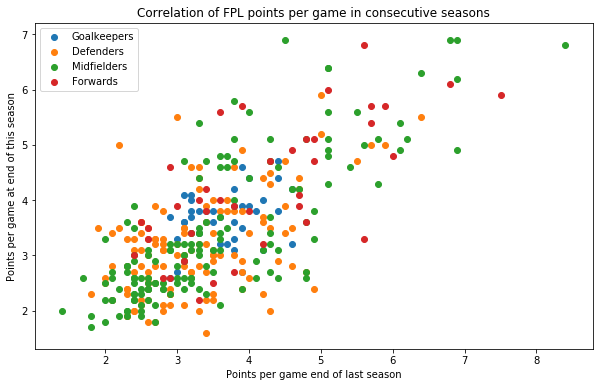

In [89]:
plt.figure(figsize=(10, 6))

plt.scatter(final_combo_df[final_combo_df["element_type"] == 1].points_per_game,
            final_combo_df[final_combo_df["element_type"] == 1].points_per_game_y,
            label = "Goalkeepers")
plt.scatter(final_combo_df[final_combo_df["element_type"] == 2].points_per_game,
            final_combo_df[final_combo_df["element_type"] == 2].points_per_game_y,
            label = "Defenders")
plt.scatter(final_combo_df[final_combo_df["element_type"] == 3].points_per_game,
            final_combo_df[final_combo_df["element_type"] == 3].points_per_game_y,
            label = "Midfielders")
plt.scatter(final_combo_df[final_combo_df["element_type"] == 4].points_per_game,
            final_combo_df[final_combo_df["element_type"] == 4].points_per_game_y,
            label = "Forwards")

plt.title("Correlation of FPL points per game in consecutive seasons")
plt.xlabel("Points per game end of last season")
plt.ylabel("Points per game at end of this season")
plt.legend()

print("Pearson correlation of points per game",
      final_combo_df.points_per_game.corr(final_combo_df.points_per_game_y)
     )
    
plt.show()

## Setting up the machine learning model
For this exercise I will use model stacking and K-fold cross validation on a selection of regression models.

Parameters have been tweaked based on several iterations of the problem but I didn't intend to spend long on that aspect - so improvement is certainly possible.

In [90]:
def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits = 5, n_repeats = 10, random_state = 0)
    scores = cross_val_score(model, X, y, scoring = 'r2', cv = cv, n_jobs = -1, error_score = 'raise')
    return scores

stack_model = StackingRegressor(
                estimators = [("KNN", KNeighborsRegressor(n_neighbors = 10, n_jobs = -1)),
                              ("LINEAR", LinearRegression()),
                              ("FOREST", RandomForestRegressor(n_estimators = 100, max_depth = 5, random_state = 0)),
                              ("SVM", SVR())],
                final_estimator = LinearRegression(),
                cv = 5)

In [91]:
print("All positions together")
print("="*20)
X = final_combo_df.iloc[:, 3:-1] # all columns except names/team and target column
y = final_combo_df.iloc[:, -1] # only the target column ("points_per_game_y")

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

results, names = [], []
models = {"KNN": KNeighborsRegressor(n_neighbors = 10, n_jobs = -1),
          "LINEAR": LinearRegression(),
          "FOREST": RandomForestRegressor(n_estimators = 100, max_depth = 5, random_state = 0),
          "SVM": SVR(),
          "STACK": stack_model}

for name, model in models.items():
    scores = evaluate_model(model, X_scaled, y)
    results.append(scores)
    names.append(name)
    print(name, "-", f"r^2 mean score: {np.mean(scores):.3f} (std dev: {np.std(scores):.3f})")

All positions together
KNN - r^2 mean score: 0.483 (std dev: 0.097)
LINEAR - r^2 mean score: 0.551 (std dev: 0.091)
FOREST - r^2 mean score: 0.535 (std dev: 0.095)
SVM - r^2 mean score: 0.546 (std dev: 0.086)
STACK - r^2 mean score: 0.562 (std dev: 0.086)


### Model accuracy = 0.562
This is clearly not an outstanding r^2 score - so with more time, I would consider adjusting features, collecting more data and looking to improve.

However given time constraints and the fact this is purely for fun/learning - we will use this model nonetheless.

### Predicting the points per game of players in the upcoming season

Now we prepare the most recent data from the 2019-20 season, which we will use to estimate the points-per-game for the coming season.

So we will apply our model to the players from Season 2019-20 (that have played enough minutes and are available this season).

In [92]:
final_19_20 = df_19_20.copy()
final_19_20.shape

(211, 25)

In [93]:
# delete players that are not available for selection in the latest data

final_19_20 = final_19_20.loc[this_season.index.intersection(final_19_20.index), :]
final_19_20

,first_name,second_name,team_name,element_type,now_cost,selected_by_percent,influence,creativity,threat,bps,points_per_game,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,strength_attack,strength_defence
code,,,,,,,,,,,,,,,,,,,,,,,,,
41270,David,Luiz Moreira Marinho,Arsenal,2,57,5.1,701.6,106.7,211.0,494,2.8,94,2809,2,1,8,42,0,0,0,5,2,0,1195.0,1215.0
54694,Pierre-Emerick,Aubameyang,Arsenal,4,109,22.4,1006.0,479.6,1369.0,807,5.7,205,3136,22,5,10,44,0,0,0,3,1,0,1195.0,1215.0
59966,Alexandre,Lacazette,Arsenal,4,92,2.4,536.4,337.7,861.0,387,3.9,118,1867,10,7,5,25,0,0,0,8,0,0,1195.0,1215.0
80201,Bernd,Leno,Arsenal,1,48,4.2,843.2,0.0,0.0,591,3.8,114,2649,0,0,7,39,0,1,0,2,0,113,1195.0,1215.0
84450,Granit,Xhaka,Arsenal,3,51,0.8,486.2,298.5,110.0,408,2.4,73,2586,1,2,10,31,0,0,0,10,0,0,1195.0,1215.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114128,Jonathan,Castro Otto,Wolves,2,55,2.5,543.6,379.2,299.0,537,3.5,123,2885,2,3,11,35,0,0,0,4,0,0,1240.0,1185.0
151589,Leander,Dendoncker,Wolves,3,44,8.5,529.2,160.6,282.0,426,2.6,100,2790,4,0,11,34,1,0,0,5,0,0,1240.0,1185.0
159533,Adama,Traoré,Wolves,3,56,13.2,727.2,786.4,583.0,522,3.5,130,2599,4,9,7,33,0,0,0,1,0,0,1240.0,1185.0


So our model will be applied to these 184 players, with hopefully enough options in each position for us to choose a high scoring squad.

In [94]:
final_19_20.element_type.value_counts(sort = False)

1    18
2    66
3    78
4    22
Name: element_type, dtype: int64

In [95]:
stack_model.fit(X_scaled, y) # as the stacking model performed best, we use it

X_predict = scaler.fit_transform(final_19_20.iloc[:, 3:])
y_prediction = stack_model.predict(X_predict)

## Final players for selection - with predicted points per game
From the `elements_df` of latest available players, we select those that we have used in our model, add our prediction for this season and then filter our the key features (from last season, except "now_cost" and "chance_") as a reference.

In [96]:
final_players = elements_df.loc[final_19_20.index,
                                ["first_name", "second_name", "team_name", "element_type",
                                 "selected_by_percent", "total_points", "minutes",
                                 "chance_of_playing_next_round",
                                 "now_cost", "points_per_game"]]
final_players["ppg_prediction"] = y_prediction
final_players["ppg_pred_over_cost"] = final_players["ppg_prediction"] / final_players["now_cost"]
final_players

,first_name,second_name,team_name,element_type,selected_by_percent,total_points,minutes,chance_of_playing_next_round,now_cost,points_per_game,ppg_prediction,ppg_pred_over_cost
code,,,,,,,,,,,,
41270,David,Luiz Moreira Marinho,Arsenal,2,1.4,94,2809,0.0,55,2.8,3.290798,0.059833
54694,Pierre-Emerick,Aubameyang,Arsenal,3,48.4,205,3136,NaN,120,5.7,5.648176,0.047068
59966,Alexandre,Lacazette,Arsenal,4,3.3,118,1867,NaN,85,3.9,4.650606,0.054713
80201,Bernd,Leno,Arsenal,1,6.8,114,2649,NaN,50,3.8,3.706207,0.074124
84450,Granit,Xhaka,Arsenal,3,0.7,73,2586,NaN,55,2.4,2.362227,0.042950
...,...,...,...,...,...,...,...,...,...,...,...,...
114128,Jonathan,Castro Otto,Wolves,2,0.1,123,2885,0.0,55,3.5,3.557925,0.064690
151589,Leander,Dendoncker,Wolves,3,2.6,100,2790,NaN,50,2.6,2.702475,0.054050
159533,Adama,Traoré,Wolves,3,20.8,130,2599,NaN,65,3.5,3.898848,0.059982


## We split the players by position
We do this ahead of running our team selection function - as there are player position constraints.

### We remove specific players 
We also **manually** remove specific players from the top 10/20 that might otherwise be selected as we have external information that means they are likely to not play significantly this season (e.g. transfer rumours, being rotated/substituted more this season, injuries etc).

#### We then pick out the top 5-10 to be used in our team selector

In [97]:
gk_choice = final_players[final_players["element_type"] == 1]
gk_choice.sort_values(by = ["ppg_pred_over_cost"], ascending = False).head(10)

,first_name,second_name,team_name,element_type,selected_by_percent,total_points,minutes,chance_of_playing_next_round,now_cost,points_per_game,ppg_prediction,ppg_pred_over_cost
code,,,,,,,,,,,,
131897,Mathew,Ryan,Brighton,1,20.1,135,3420,NaN,45,3.6,3.747293,0.083273
58376,Alex,McCarthy,Southampton,1,23.6,104,2520,NaN,45,3.7,3.585924,0.079687
21205,Tom,Heaton,Aston Villa,1,0.1,59,1794,0.0,45,3.0,3.434728,0.076327
37915,Hugo,Lloris,Spurs,1,5.2,98,1808,NaN,55,4.7,4.190632,0.076193
67089,Martin,Dubravka,Newcastle,1,0.5,143,3420,0.0,50,3.8,3.800200,0.076004
116535,Alisson,Ramses Becker,Liverpool,1,12.5,122,2543,NaN,60,4.2,4.551672,0.075861
109745,Kepa,Arrizabalaga,Chelsea,1,2.3,90,2970,NaN,50,2.7,3.748711,0.074974
111234,Jordan,Pickford,Everton,1,4.7,117,3420,NaN,50,3.1,3.708657,0.074173
80201,Bernd,Leno,Arsenal,1,6.8,114,2649,NaN,50,3.8,3.706207,0.074124


In [98]:
# delete injured and transfer/rotation risks

# Heaton (inj), Leno (rot), Henderson (rot), Guaita (trf)
# Fabianski (trf), De Gea (rot), Dubravka (inj), Arrizabalaga (rot/trf)
gk_choice.drop([21205, 80201, 172649, 40836, 37096,
                51940, 67089, 109745], errors = "ignore", inplace = True)

C:\Users\Dexx6\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [99]:
gk_top = gk_choice.sort_values(by = ["ppg_pred_over_cost"], ascending = False).head(5)
gk_top

,first_name,second_name,team_name,element_type,selected_by_percent,total_points,minutes,chance_of_playing_next_round,now_cost,points_per_game,ppg_prediction,ppg_pred_over_cost
code,,,,,,,,,,,,
131897,Mathew,Ryan,Brighton,1,20.1,135,3420,NaN,45,3.6,3.747293,0.083273
58376,Alex,McCarthy,Southampton,1,23.6,104,2520,NaN,45,3.7,3.585924,0.079687
37915,Hugo,Lloris,Spurs,1,5.2,98,1808,NaN,55,4.7,4.190632,0.076193
116535,Alisson,Ramses Becker,Liverpool,1,12.5,122,2543,NaN,60,4.2,4.551672,0.075861
111234,Jordan,Pickford,Everton,1,4.7,117,3420,NaN,50,3.1,3.708657,0.074173


In [100]:
def_choice = final_players[final_players["element_type"] == 2]
def_choice.sort_values(by = ["ppg_pred_over_cost"], ascending = False).head(20)

,first_name,second_name,team_name,element_type,selected_by_percent,total_points,minutes,chance_of_playing_next_round,now_cost,points_per_game,ppg_prediction,ppg_pred_over_cost
code,,,,,,,,,,,,
87835,Matt,Doherty,Spurs,2,26.2,167,2836,NaN,60,4.6,4.742852,0.079048
108416,John,Egan,Sheffield Utd,2,17.7,133,3187,NaN,50,3.7,3.698814,0.073976
57410,Nicolás,Otamendi,Man City,2,0.7,82,1710,NaN,50,3.4,3.602957,0.072059
39487,Erik,Pieters,Burnley,2,1.5,77,1876,NaN,45,3.2,3.239114,0.071980
97032,Virgil,van Dijk,Liverpool,2,26.6,178,3420,NaN,65,4.7,4.583851,0.070521
90585,Willy,Boly,Wolves,2,2.4,97,1980,NaN,55,4.4,3.874368,0.070443
102380,Antonio,Rüdiger,Chelsea,2,2.3,63,1710,NaN,50,3.1,3.490178,0.069804
122798,Andrew,Robertson,Liverpool,2,13.4,181,3111,NaN,70,5.0,4.883626,0.069766
83299,Lewis,Dunk,Brighton,2,9.5,128,3230,NaN,50,3.6,3.473230,0.069465


In [101]:
# delete injured and transfer/rotation risks

# Otamendi (trf), Pieters (rot), Cahill (inj), Chilwell (inj)
# Rudiger (inj), Bardsley (rot), Taylor (inj), Shaw (inj)
def_choice.drop([57410, 39487, 19419, 172850, 102380,
                17997, 103914, 106760], errors = "ignore", inplace = True)
def_top = def_choice.sort_values(by = ["ppg_pred_over_cost"], ascending = False).head(10)
def_top

,first_name,second_name,team_name,element_type,selected_by_percent,total_points,minutes,chance_of_playing_next_round,now_cost,points_per_game,ppg_prediction,ppg_pred_over_cost
code,,,,,,,,,,,,
87835,Matt,Doherty,Spurs,2,26.2,167,2836,NaN,60,4.6,4.742852,0.079048
108416,John,Egan,Sheffield Utd,2,17.7,133,3187,NaN,50,3.7,3.698814,0.073976
97032,Virgil,van Dijk,Liverpool,2,26.6,178,3420,NaN,65,4.7,4.583851,0.070521
90585,Willy,Boly,Wolves,2,2.4,97,1980,NaN,55,4.4,3.874368,0.070443
122798,Andrew,Robertson,Liverpool,2,13.4,181,3111,NaN,70,5.0,4.883626,0.069766
83299,Lewis,Dunk,Brighton,2,9.5,128,3230,NaN,50,3.6,3.473230,0.069465
169187,Trent,Alexander-Arnold,Liverpool,2,56.2,210,3173,NaN,75,5.5,5.075277,0.067670
111931,Ricardo Domingos,Barbosa Pereira,Leicester,2,0.2,123,2520,0.0,60,4.4,3.991965,0.066533
41328,César,Azpilicueta,Chelsea,2,8.2,130,3229,NaN,60,3.6,3.955693,0.065928


In [102]:
mid_choice = final_players[final_players["element_type"] == 3]
mid_choice.sort_values(by = ["ppg_pred_over_cost"], ascending = False).head(20)

,first_name,second_name,team_name,element_type,selected_by_percent,total_points,minutes,chance_of_playing_next_round,now_cost,points_per_game,ppg_prediction,ppg_pred_over_cost
code,,,,,,,,,,,,
153723,John,Lundstram,Sheffield Utd,3,13.7,144,2452,NaN,55,4.2,4.137827,0.075233
103025,Riyad,Mahrez,Man City,3,2.0,175,1934,NaN,85,5.3,5.621620,0.066137
85971,Heung-Min,Son,Spurs,3,30.0,169,2478,NaN,90,5.6,5.791246,0.064347
168580,Ayoze,Pérez,Leicester,3,3.7,129,1998,NaN,65,3.9,4.146991,0.063800
116216,Leandro,Trossard,Brighton,3,0.4,104,2004,NaN,60,3.4,3.809123,0.063485
195851,Scott,McTominay,Man Utd,3,0.3,74,1765,NaN,50,2.7,3.135903,0.062718
148508,Mahmoud Ahmed,Ibrahim Hassan,Aston Villa,3,1.3,98,1936,NaN,55,2.9,3.434564,0.062447
170137,Allan,Saint-Maximin,Newcastle,3,23.2,92,1860,NaN,55,3.5,3.423907,0.062253
176413,Christian,Pulisic,Chelsea,3,10.4,127,1717,100.0,85,5.1,5.242621,0.061678


In [103]:
# delete injured and transfer/rotation risks

# Silva (inj), Maddison (inj), Shelvey (inj), Mooy (inj)
# Henderson (inj), McTominay (rot)
mid_choice.drop([165809, 172780, 50232, 74471, 56979,
                195851], errors = "ignore", inplace = True)
mid_top = mid_choice.sort_values(by = ["ppg_pred_over_cost"], ascending = False).head(10)
mid_top

,first_name,second_name,team_name,element_type,selected_by_percent,total_points,minutes,chance_of_playing_next_round,now_cost,points_per_game,ppg_prediction,ppg_pred_over_cost
code,,,,,,,,,,,,
153723,John,Lundstram,Sheffield Utd,3,13.7,144,2452,NaN,55,4.2,4.137827,0.075233
103025,Riyad,Mahrez,Man City,3,2.0,175,1934,NaN,85,5.3,5.621620,0.066137
85971,Heung-Min,Son,Spurs,3,30.0,169,2478,NaN,90,5.6,5.791246,0.064347
168580,Ayoze,Pérez,Leicester,3,3.7,129,1998,NaN,65,3.9,4.146991,0.063800
116216,Leandro,Trossard,Brighton,3,0.4,104,2004,NaN,60,3.4,3.809123,0.063485
148508,Mahmoud Ahmed,Ibrahim Hassan,Aston Villa,3,1.3,98,1936,NaN,55,2.9,3.434564,0.062447
170137,Allan,Saint-Maximin,Newcastle,3,23.2,92,1860,NaN,55,3.5,3.423907,0.062253
176413,Christian,Pulisic,Chelsea,3,10.4,127,1717,100.0,85,5.1,5.242621,0.061678
108823,Bamidele,Alli,Spurs,3,3.9,117,1845,NaN,80,4.7,4.816488,0.060206


In [104]:
fwd_choice = final_players[final_players["element_type"] == 4]
fwd_choice.sort_values(by = ["ppg_pred_over_cost"], ascending = False)

,first_name,second_name,team_name,element_type,selected_by_percent,total_points,minutes,chance_of_playing_next_round,now_cost,points_per_game,ppg_prediction,ppg_pred_over_cost
code,,,,,,,,,,,,
57531,Michail,Antonio,West Ham,4,11.3,111,1767,NaN,65,4.6,4.769661,0.073379
103123,Sébastien,Haller,West Ham,4,0.6,102,2259,NaN,65,3.2,4.157606,0.063963
115382,Neal,Maupay,Brighton,4,1.9,131,2763,NaN,65,3.5,4.089605,0.062917
148225,Anthony,Martial,Man Utd,4,12.5,200,2625,NaN,90,6.2,5.513480,0.061261
173879,Tammy,Abraham,Chelsea,4,5.2,153,2206,NaN,75,4.5,4.578940,0.061053
44683,Jay,Rodriguez,Burnley,4,0.9,100,2002,NaN,60,2.8,3.642639,0.060711
60689,Chris,Wood,Burnley,4,2.6,136,2436,NaN,65,4.2,3.894078,0.059909
75115,Callum,Wilson,Newcastle,4,8.7,116,2906,NaN,65,3.3,3.859630,0.059379
102057,Raúl,Jiménez,Wolves,4,19.0,194,3241,NaN,85,5.1,5.024556,0.059112


In [105]:
# delete injured and transfer/rotation risks

# Antonio (rot), Abraham (rot)
fwd_choice.drop([57531, 173879], errors = "ignore", inplace = True)
fwd_top = fwd_choice.sort_values(by = ["ppg_pred_over_cost"], ascending = False).head(7)
fwd_top

,first_name,second_name,team_name,element_type,selected_by_percent,total_points,minutes,chance_of_playing_next_round,now_cost,points_per_game,ppg_prediction,ppg_pred_over_cost
code,,,,,,,,,,,,
103123,Sébastien,Haller,West Ham,4,0.6,102,2259,NaN,65,3.2,4.157606,0.063963
115382,Neal,Maupay,Brighton,4,1.9,131,2763,NaN,65,3.5,4.089605,0.062917
148225,Anthony,Martial,Man Utd,4,12.5,200,2625,NaN,90,6.2,5.513480,0.061261
44683,Jay,Rodriguez,Burnley,4,0.9,100,2002,NaN,60,2.8,3.642639,0.060711
60689,Chris,Wood,Burnley,4,2.6,136,2436,NaN,65,4.2,3.894078,0.059909
75115,Callum,Wilson,Newcastle,4,8.7,116,2906,NaN,65,3.3,3.859630,0.059379
102057,Raúl,Jiménez,Wolves,4,19.0,194,3241,NaN,85,5.1,5.024556,0.059112


## Brute force optimiser
Below we use brute force - calculating every possible combination of a 15 person squad with the following constraints:
     * 2 goalkeepers
     * 5 defenders
     * 5 midfielders
     * 3 forwards
     * No more than 3 players from any team
     * Overall squad 'cost' <= 1000

In [106]:
def brute_force_team_selector(gks, defs, mids, fwds):
    
    team_combos = [] # will be list of team dataframes
    
    for gk1, gk2 in list(combinations(gks.index, 2)):
        new_team = pd.DataFrame(columns = ["code", "first_name", "second_name", "team_name", "element_type",
                                 "selected_by_percent", "total_points", "minutes", "points_per_game",
                                 "ppg_pred_over_cost", "now_cost", "ppg_prediction"])
        new_gks = new_team.append(gks.loc[[gk1, gk2], :], sort = False)
        
        for def1, def2, def3, def4, def5 in list(combinations(defs.index, 5)):
            new_defs = new_gks.append(defs.loc[[def1, def2, def3, def4, def5], :], sort = False)
            
            for mid1, mid2, mid3, mid4, mid5 in list(combinations(mids.index, 5)):
                new_mids = new_defs.append(mids.loc[[mid1, mid2, mid3, mid4, mid5], :], sort = False)
                
                for fwd1, fwd2, fwd3 in list(combinations(fwds.index, 3)):
                    new_fwds = new_mids.append(fwds.loc[[fwd1, fwd2, fwd3], :], sort = False)

                    team_combos.append(new_fwds)
    
    filtered_teams = {}
    for df in team_combos:
        team_cost = df.now_cost.sum()
        if (team_cost <= 1000) and (df.team_name.value_counts() < 4).all():
            filtered_teams[df.ppg_prediction.sum()] = df
            
    return filtered_teams

Below I show the elapsed time for the function - around 1 minute with the below settings.

I did also run the data on larger sets of the players, however it yields the same top team below.

In [107]:
start = time.time()

team_choices_dfs = brute_force_team_selector(gk_top[:-2], def_top[:-3], mid_top[:-3], fwd_top[:-3])

end = time.time()
print("Time elapsed in minutes:", (end - start)/60)

Time elapsed in minutes: 1.0789864142735799


In [108]:
len(team_choices_dfs)

3942

In [109]:
max(team_choices_dfs) # max predicted points per game for total 15 person squad

68.36539682952008

# Final team selection
Based on the output of the above, the below was my final team selection.

I chose the formation based on the highest points per game output possible (formation constaints are 1 GK, >= 3 DEF and >= 1 FWD).

I chose the captain/vice captain based on highest points per game - but tweaked for my intuition of likelihood to play most minutes in the full season.

The idea will be to make no changes to this team unless forced to by injuries/transfers/other factors meaning these players are unlikely to play most of the season.

In [110]:
team_choices_dfs[max(team_choices_dfs)].sort_values(by = ['element_type', 'ppg_prediction'], ascending = False)

,code,first_name,second_name,team_name,element_type,selected_by_percent,total_points,minutes,points_per_game,ppg_pred_over_cost,now_cost,ppg_prediction,chance_of_playing_next_round
148225,NaN,Anthony,Martial,Man Utd,4,12.5,200,2625,6.2,0.061261,90,5.513480,NaN
103123,NaN,Sébastien,Haller,West Ham,4,0.6,102,2259,3.2,0.063963,65,4.157606,NaN
115382,NaN,Neal,Maupay,Brighton,4,1.9,131,2763,3.5,0.062917,65,4.089605,NaN
85971,NaN,Heung-Min,Son,Spurs,3,30.0,169,2478,5.6,0.064347,90,5.791246,NaN
103025,NaN,Riyad,Mahrez,Man City,3,2.0,175,1934,5.3,0.066137,85,5.621620,NaN
168580,NaN,Ayoze,Pérez,Leicester,3,3.7,129,1998,3.9,0.063800,65,4.146991,NaN
153723,NaN,John,Lundstram,Sheffield Utd,3,13.7,144,2452,4.2,0.075233,55,4.137827,NaN
116216,NaN,Leandro,Trossard,Brighton,3,0.4,104,2004,3.4,0.063485,60,3.809123,NaN
169187,NaN,Trent,Alexander-Arnold,Liverpool,2,56.2,210,3173,5.5,0.067670,75,5.075277,NaN
122798,NaN,Andrew,Robertson,Liverpool,2,13.4,181,3111,5.0,0.069766,70,4.883626,NaN
